In [1]:
# Import 
import os
import time
import json
import datetime
import sys

import pandas as pd
import numpy as np
from matplotlib import rcParams

from pathlib import Path
from tyssue import Sheet
from tyssue.io import hdf5

from tyssue.dynamics.sheet_gradients import height_grad
from tyssue.dynamics import units, effectors, model_factory
from tyssue.solvers.quasistatic import QSSolver
from tyssue.draw import sheet_view
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.dpi'] = 200

sys.path.append("..")
from peripodial.polarity import model
from peripodial.dynamics import EllipsoidLameGeometry as geom
from peripodial.anisotropy import anysotropy as aniso
from peripodial.anisotropy import face_orientation
from peripodial.polarity import update_weights
from peripodial.draw import draw_half_N_sheet
from joblib import Parallel, delayed
from tqdm import tqdm

vispy  won't work


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dsets = hdf5.load_datasets('../json_hdf5/lumen_elasticity.hdf5',
                               data_names=['vert', 'edge', 'face'])

with open('../json_hdf5/lumen_elasticity.json', 'r+') as fp:
    specs = json.load(fp)

sheet = Sheet('spherical', dsets)

sheet.update_specs(specs, reset=True)
geom.update_all(sheet)

In [4]:
specs = {'face': {'prefered_perimeter': 2.0},
 'settings': {'geometry': 'spherical',
  'height_axis': 'z',
  'lumen_prefered_vol': 5600,
  'lumen_vol_elasticity': 1e-4,
  'threshold_length': 0.01,
  'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
  'barrier_radius': 12.5},
 'vert': {'barrier_elasticity': 1.0, 'delta_rho': 0},
        }

In [5]:
elasticity_lumen_values =  np.logspace(-6, -2, 16)
elasticity_barrier_values = np.logspace(-3, 0, 16)


els_lumen, els_barrier = np.meshgrid(elasticity_lumen_values, elasticity_barrier_values)

"""this function allows to apply barrier elasticity, lumen volume elasticity 
and to calculate diameter, anisocell, area and perimeter of the cell"""
solver = QSSolver(with_t1=False, with_t3=False)

def multi_parameters(l, b):
    sheet_copy = sheet.copy()
    geom.update_all(sheet_copy)
    # add some position noise to avoid being stuck in a local min
    sheet_copy.vert_df[['x', 'y', 'z']] += np.random.normal(0.0, 1e-3, (sheet.Nv, 3))
    sheet_copy.settings['lumen_vol_elasticity']= l
    sheet_copy.vert_df['barrier_elasticity'] = b
    res = solver.find_energy_min(sheet_copy, geom, model, options={"gtol": 1e-8})
    length_max = np.percentile(sheet_copy.vert_df["z"], 99)
    length_min = np.percentile(sheet_copy.vert_df["z"], 1)
    length = length_max-length_min
    
    center_verts =  sheet_copy.vert_df.loc[np.abs(sheet.vert_df["z"]) < 1]
    sheet_copy.face_df['anisotropy'] = aniso(sheet_copy, coords = ['x','y','z'])
    center = np.abs(sheet_copy.face_df["z"]) < sheet_copy.face_df["z"].max()*0.75
    aniso_cell = sheet_copy.face_df.loc[center, 'anisotropy'].mean()
    area = sheet_copy.face_df.loc[center, 'area'].mean()#area of the cell
    c_perimeter = sheet_copy.face_df.loc[center,'perimeter'].mean()
    volume = sheet_copy.settings["lumen_vol"]
    center_diameter = 2 * ((sheet_copy.vert_df[["x", "y"]]**2).sum(axis=1))**2
    
    return res['success'], length, aniso_cell, area, c_perimeter, volume, center_diameter, l, b


In [6]:
#parrallèlisation de barrier_elasticity et lume_vol _elasticity
results = Parallel(n_jobs=8)(delayed(multi_parameters)(l, b) for l, b in tqdm(zip(els_lumen.ravel(), els_barrier.ravel())))


192it [42:05, 13.15s/it]


### Parralelisation

In [7]:
# Convert results to DataFrame
df_results = pd.DataFrame.from_records(results, columns=['res', 'diameter', 'aniso_cell', 'area', 'c_perimeter', 'volume', 'center_diameter', 'l', 'b'])
# Save the DataFrame to a CSV file
df_results.to_csv('df_results.csv', index=True)

In [8]:
df_results= pd.read_csv('df_results.csv')

In [9]:
df_results

,Unnamed: 0,res,diameter,aniso_cell,area,c_perimeter,volume,center_diameter,l,b
0,0,True,28.612647,1.370695,0.746646,3.300453,2850.239378,vert\n0 4867.853401\n1 3094.443294...,0.000001,0.001
1,1,True,28.985728,1.349971,0.749363,3.301096,2814.491478,vert\n0 4130.805906\n1 2614.522548...,0.000002,0.001
2,2,True,28.756211,1.459255,0.758980,3.346912,3166.499171,vert\n0 5365.899481\n1 4008.313188...,0.000003,0.001
3,3,True,29.211742,1.478104,0.776270,3.388089,3367.172515,vert\n0 5655.075240\n1 4251.428798...,0.000006,0.001
4,4,True,29.238253,1.577240,0.802770,3.472026,3747.901255,vert\n0 6119.410474\n1 5703.411606...,0.000012,0.001
...,...,...,...,...,...,...,...,...,...,...
187,187,True,31.033246,1.733243,0.995319,3.918790,5518.811128,vert\n0 11299.911439\n1 11543.4132...,0.000858,1.000
188,188,True,31.032650,1.734246,0.999605,3.927597,5555.324843,vert\n0 11501.333788\n1 11692.2928...,0.001585,1.000
189,189,True,30.967950,1.735216,1.003033,3.935080,5575.910295,vert\n0 11656.458774\n1 11862.3020...,0.002929,1.000
190,190,True,31.044217,1.735355,1.003017,3.934926,5586.873304,vert\n0 11637.567592\n1 11804.2449...,0.005412,1.000


In [10]:
energies = model.compute_energy(sheet, full_output=True)


In [11]:
energies = {l: e for l, e in zip(model.labels, energies)}

In [12]:
energies.keys()

dict_keys(['Barrier elasticity', 'Apical basal tension', 'Perimeter Elasticity', 'Area elasticity', 'Lumen volume elasticity'])

In [13]:
energies['Perimeter Elasticity'].sum()

259.3794993659154

In [14]:
model.labels

['Barrier elasticity',
 'Apical basal tension',
 'Perimeter Elasticity',
 'Area elasticity',
 'Lumen volume elasticity']

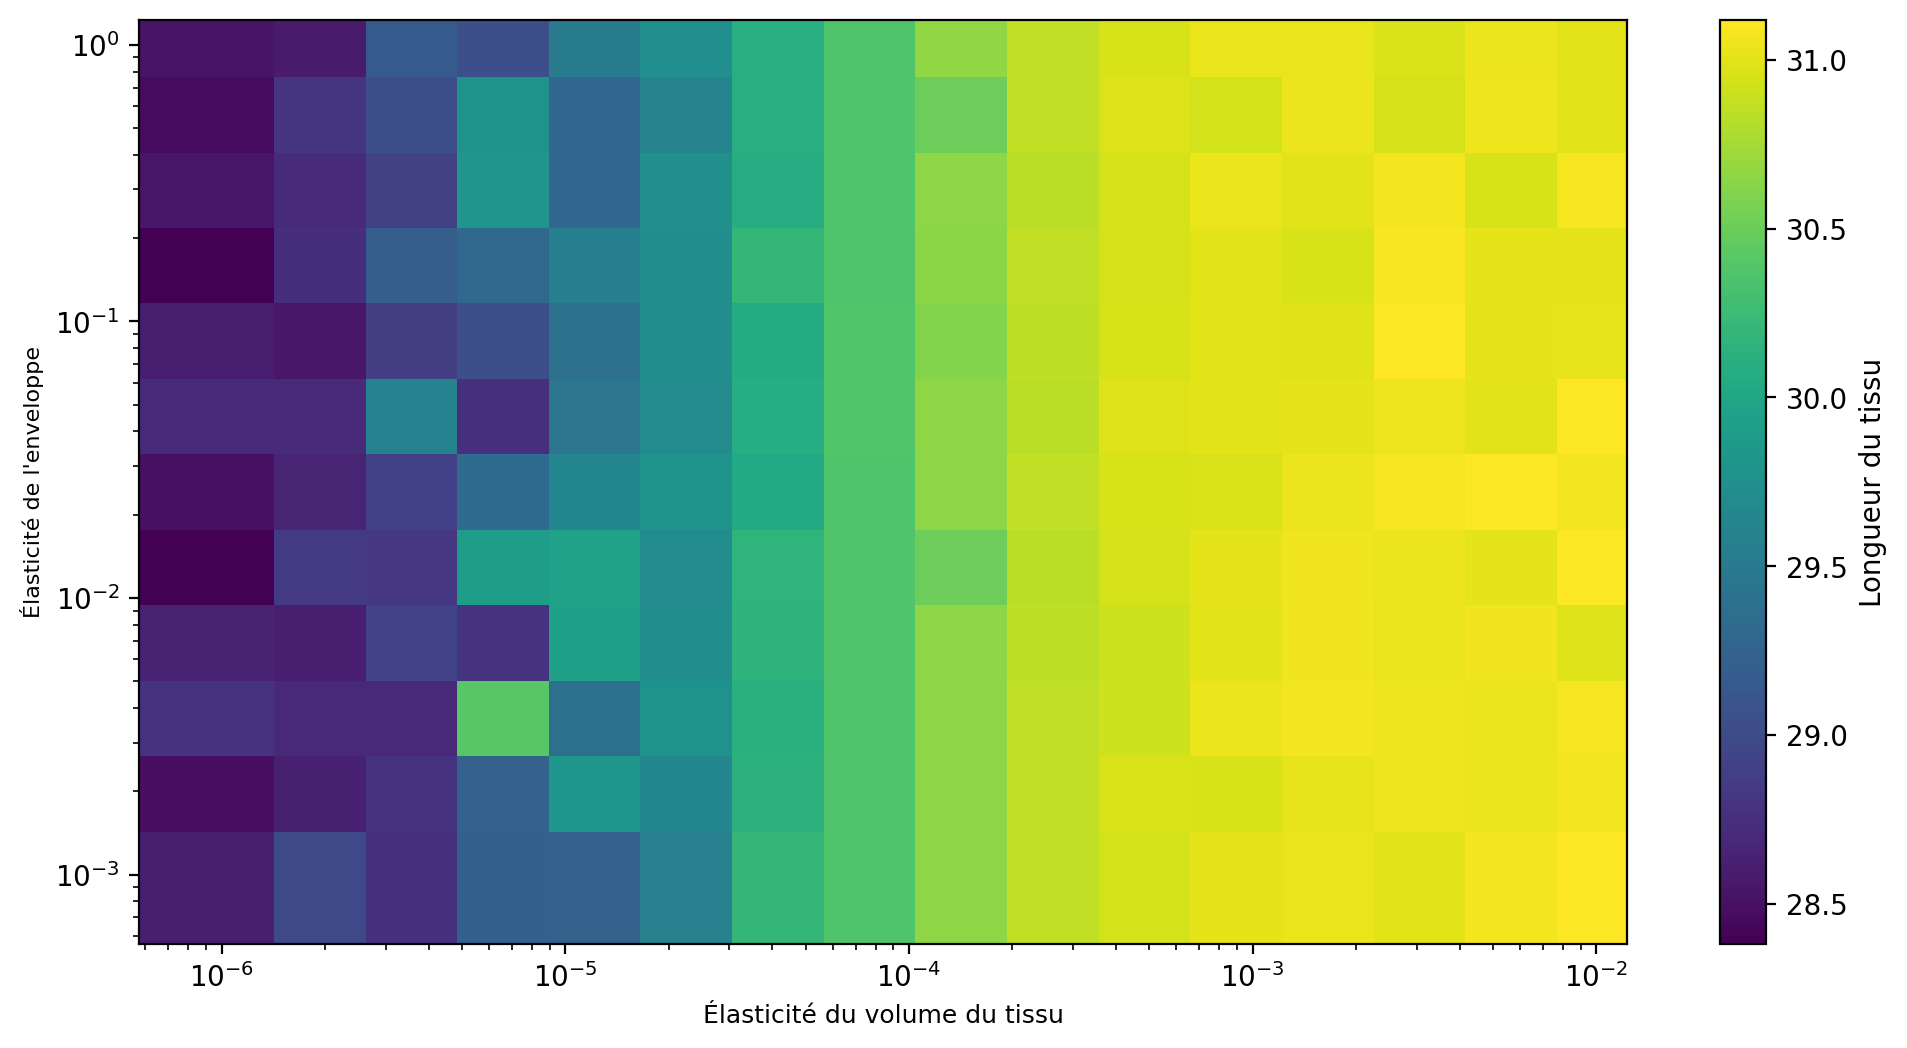

In [28]:
elasticity_lumen_values =  np.logspace(-6, -2, 16)
elasticity_barrier_values = np.logspace(-3, 0, 12)
# Définition des valeurs pour les axes b_list_s et l_list_s
l_list_s = elasticity_lumen_values
b_list_s = elasticity_barrier_values

diameter_array = df_results["diameter"].values
diameter_array_2d = diameter_array.reshape(b_list_s.size, l_list_s.size)

fig, axs = plt.subplots(1, figsize=(12, 6))
c = axs.pcolor(l_list_s, b_list_s, diameter_array_2d, cmap='viridis',
               vmin=diameter_array_2d.min(), vmax=diameter_array_2d.max())
fig.colorbar(c, ax=axs, label='Longueur du tissu')
axs.set_ylabel('Élasticité de l\'enveloppe', fontsize=8)
axs.set_xlabel('Élasticité du volume du tissu', fontsize=9)
axs.set_yscale('log')
axs.set_xscale('log')

fig.savefig('../image/Length_2D.png', transparent=False, bbox_inches='tight')
plt.show()

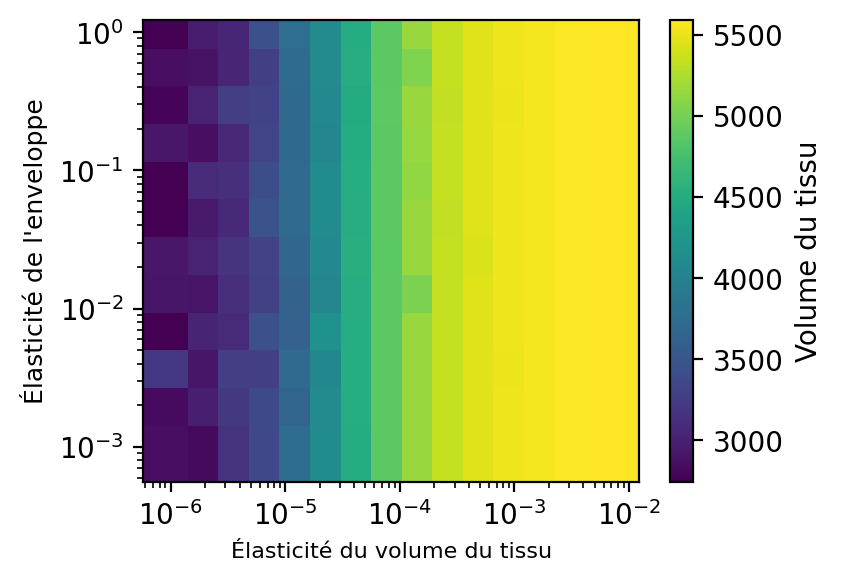

In [19]:
volume_array = df_results["volume"].values
volume_array_2d = volume_array.reshape(b_list_s.size, l_list_s.size)

fig, axs = plt.subplots(1, figsize=(4, 3))
c = axs.pcolor(l_list_s, b_list_s, volume_array_2d, cmap='viridis',
               vmin=volume_array_2d.min(), vmax=volume_array_2d.max())
fig.colorbar(c, ax=axs, label='Volume du tissu')
axs.set_xlabel('Élasticité du volume du tissu', fontsize=8)
axs.set_ylabel('Élasticité de l\'enveloppe', fontsize=9)
axs.set_yscale('log')
axs.set_xscale('log')

fig.savefig('../image/volume_2D.png', transparent=False, bbox_inches='tight')
plt.show()

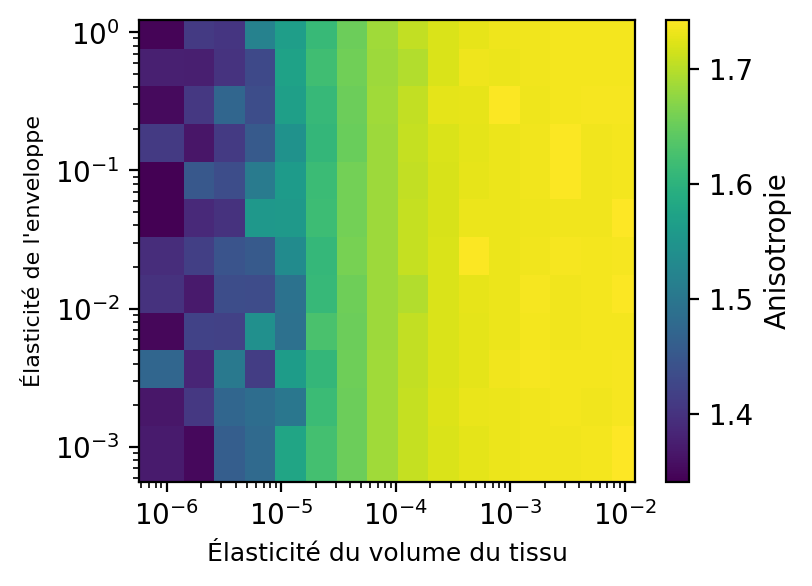

In [23]:
# Définition des valeurs pour les axes b_list_s et l_list_s
l_list_s = elasticity_lumen_values
b_list_s = elasticity_barrier_values

aniso_cell_array = df_results["aniso_cell"].values
aniso_cell_array_2d = aniso_cell_array.reshape(b_list_s.size, l_list_s.size)

fig, axs = plt.subplots(1, figsize=(4, 3))
c = axs.pcolor(l_list_s, b_list_s, aniso_cell_array_2d, cmap='viridis',
               vmin=aniso_cell_array_2d.min(), vmax=aniso_cell_array_2d.max())
fig.colorbar(c, ax=axs, label='Anisotropie')
plt.ylabel('Élasticité de l\'enveloppe', fontsize=8)
plt.xlabel('Élasticité du volume du tissu', fontsize=9)
plt.yscale('log')
plt.xscale('log')

plt.savefig('../image/Aniso_2D.png', transparent=False, bbox_inches='tight')
plt.show()




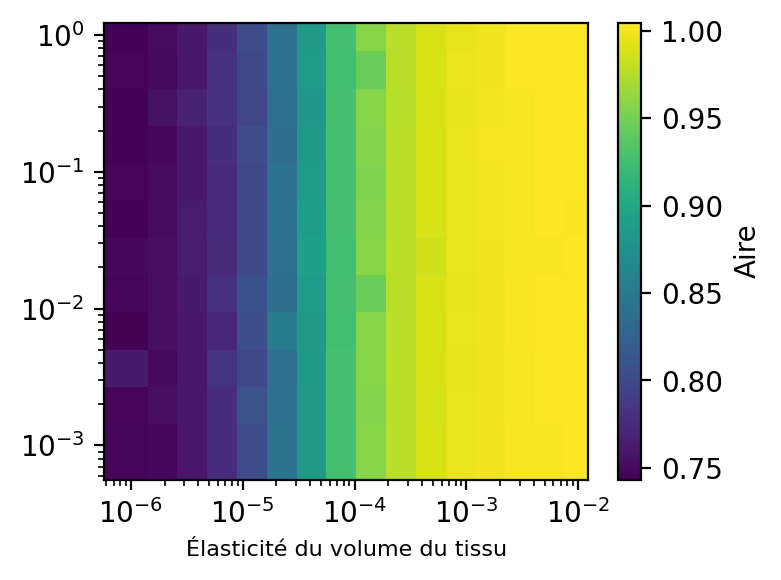

In [25]:
area_array = df_results["area"].values
area_array_2d = area_array.reshape(b_list_s.size, l_list_s.size)


# Création du graphique avec pcolor()
fig, axs = plt.subplots(1, figsize=(4, 3))

d = axs.pcolor(l_list_s, b_list_s, area_array_2d, cmap='viridis',
               vmin=area_array_2d.min(), vmax=area_array_2d.max())

fig.colorbar(d, ax=axs, label='Aire')
plt.xlabel('Élasticité du volume du tissu', fontsize=8)
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()

plt.savefig('../image/Area_2D.png', transparent=False, bbox_inches='tight')


plt.show()

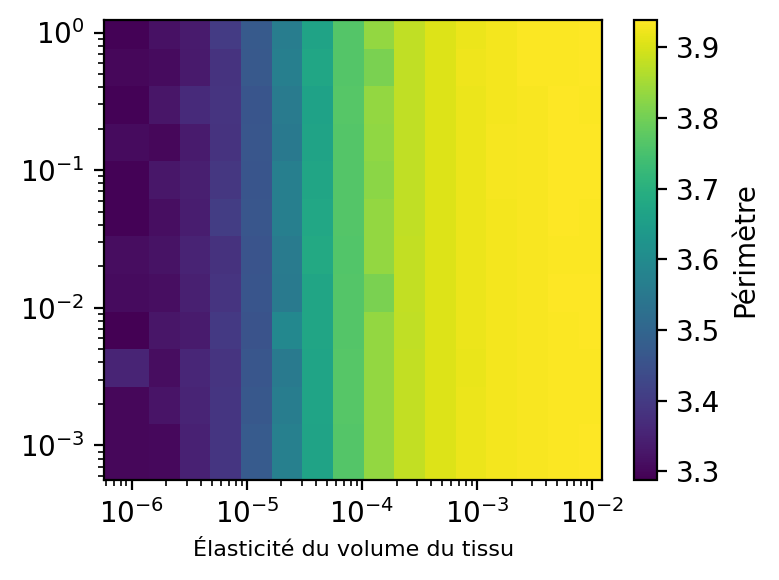

In [26]:
perimeter_array = df_results["c_perimeter"].values
perimeter_array_2d = perimeter_array.reshape(b_list_s.size, l_list_s.size)


# Création du graphique avec pcolor()
fig, axs = plt.subplots(1, figsize=(4, 3))

d = axs.pcolor(l_list_s, b_list_s, perimeter_array_2d, cmap='viridis',
               vmin=perimeter_array_2d.min(), vmax=perimeter_array_2d.max())

fig.colorbar(d, ax=axs, label='Périmètre')
plt.xlabel('Élasticité du volume du tissu', fontsize=8)
plt.yscale('log')
plt.xscale('log')
plt.tight_layout()

plt.savefig('../image/Peri_2D.png', transparent=False, bbox_inches='tight')


plt.show()

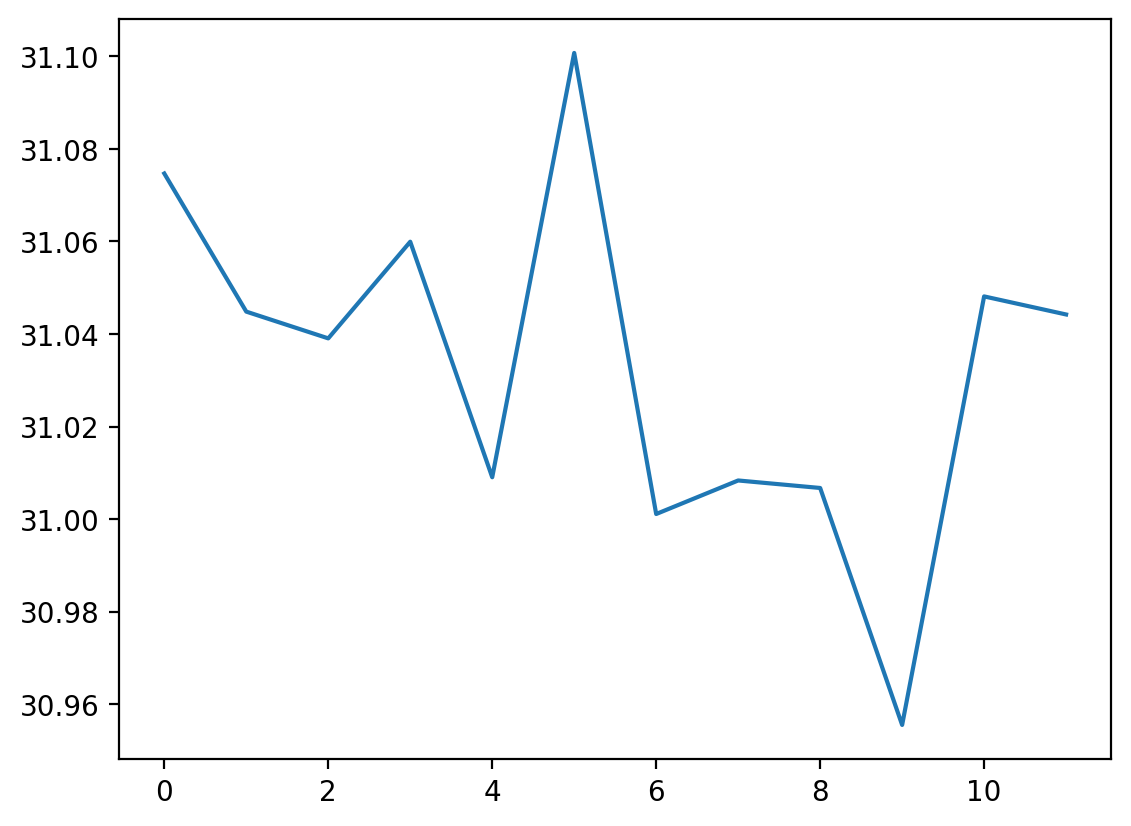

In [30]:
plt.plot(diameter_array_2d[:,-2])

In [ ]:
# Saving each row of the DataFrame to a JSON file
for i, row in df_results.iterrows():
    print(f"Processing {i+1} / {len(df_results)}")
    
    # Retrieving data from the row
    l = row['l']['value']
    b = row['b']['value']
    
    # Assigning values without checking the type
    diameter = row['diameter']
    aniso_cell = row['aniso_cell']
    area = row['area']
    c_perimeter = row['c_perimeter']

    
    # Create a dictionary to stock the data
    specs = {
        'face': {'prefered_perimeter': 3.8},
        'settings': {
            'geometry': 'spherical',
            'height_axis': 'z',
            'lumen_prefered_vol': 5700,
            'lumen_vol_elasticity': l,
            'threshold_length': 0.01,
            'rosette_kwargs': {'threshold_length': 0.01, 'p_4': 0.01, 'p_5': 0.001},
            'barrier_radius': 13
        },
        'vert': {'barrier_elasticity': b, 'delta_rho': 0},
        'metrics': {'diameter': diameter, 'c_perimeter': c_perimeter, 'area':area, 'aniso_cell': aniso_cell},
    }
    
    # Enregister the file
    filename = f"../json_hdf5/Simulation/measures_l{round(float(l), 5)}_b{round(float(b), 5)}.json"
    
    # Enregistrement des données dans un fichier JSON
    with Path(filename).open("w") as fh:
        json.dump(specs, fh, indent=8)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Load the DataFrame from the CSV file
df_results = pd.read_csv('df_results.csv')

In [ ]:
# Transform the columns of a dataframe in lists
def dataframe_to_dict_of_lists(df):
    lists_dict = {column: df[column].tolist() for column in df.columns}
    
    return lists_dict


# Using of the function to transform df_results in lists
dict_of_lists_from_df = dataframe_to_dict_of_lists(df_results)

In [ ]:
#create a list to plot the evolution
diameter_list = dict_of_lists_from_df['diameter']
aniso_cell_list = dict_of_lists_from_df['aniso_cell']
area_list = dict_of_lists_from_df['area']
c_perimeter = dict_of_lists_from_df['c_perimeter']
l_list = dict_of_lists_from_df['l']
b_list = dict_of_lists_from_df['b']

In [ ]:
my_dict = {}

for i in range(1, 101):
    my_dict[i] = (l_list[i-1], b_list[i-1])

my_list = list(my_dict.items())

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
def logistic_func(x, L, k, x0):
    return L / (1 + np.exp(-k * (x - x0)))


In [ ]:
x_data = np.array(l_list)
y_data = np.array(diameter_list)

initial_guess = [max(y_data), 1, np.median(x_data)]
params, covariance = curve_fit(logistic_func, x_data, y_data, p0=initial_guess, maxfev=20000)
L, k, x0 = params
L, k, x0 = params


In [35]:
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, label='Data', color=colors[1], marker='o', s=20, alpha=0.6)
x_fit = np.linspace(min(x_data), max(x_data), 100)
y_fit = logistic_func(x_fit, L, k, x0)
plt.plot(x_fit, y_fit, label=f'Logistic Fit: L={L:.2f}, k={k:.2f}, x0={x0:.2f}', color='red')
plt.xlabel('elasticity of the envelope', fontsize=12)
plt.ylabel('length of the tissue', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()


NameError: name 'colors' is not defined

<Figure size 1600x1200 with 0 Axes>

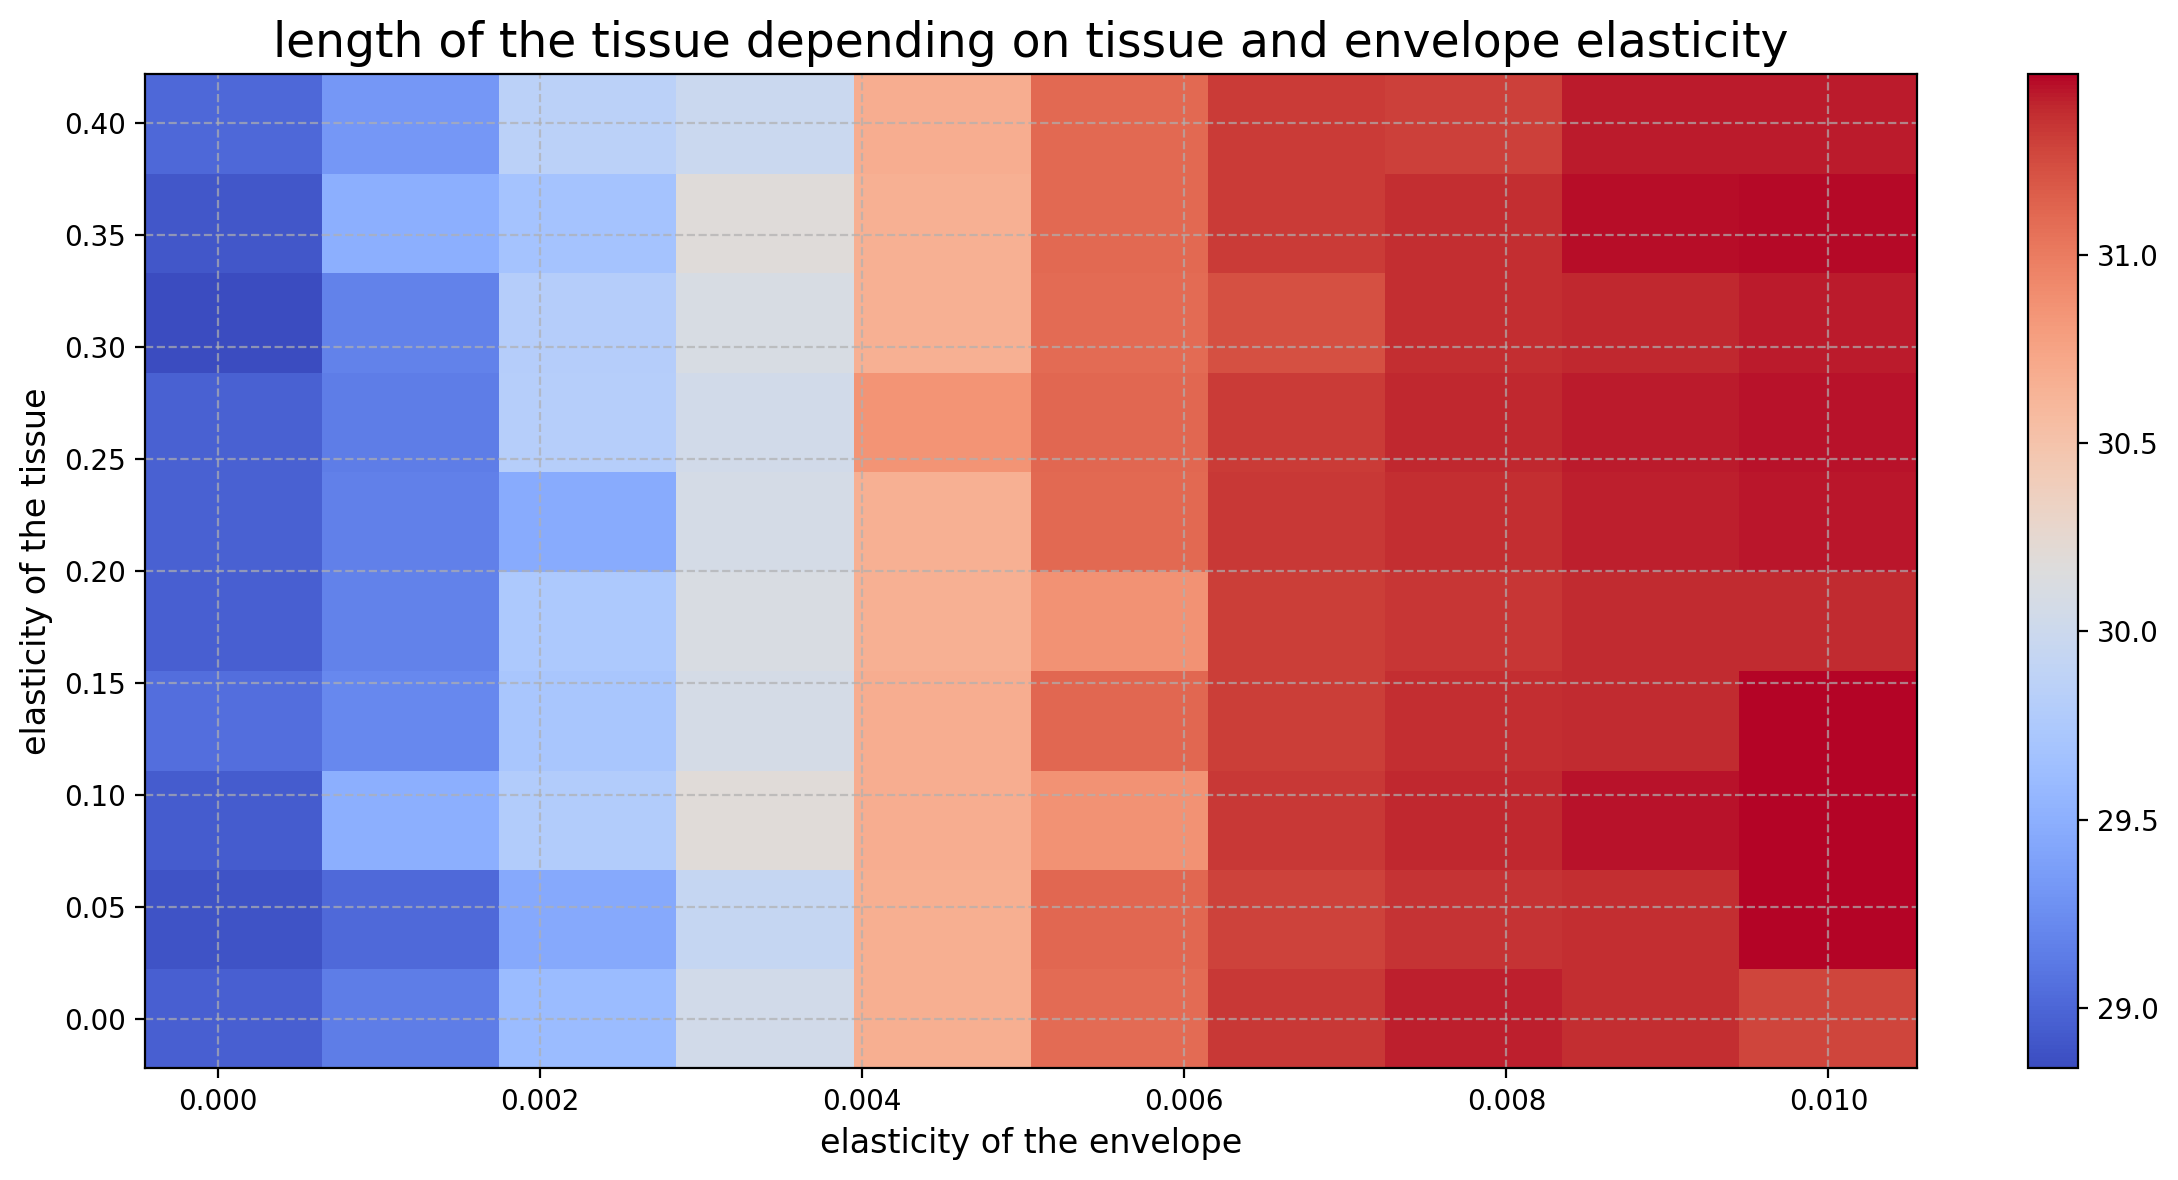

In [60]:
b_list_s = np.linspace(1e-4, 1e-2, 10)
l_list_s = np.linspace(0.0, 0.4, 10)
diameter_list_s = np.array(diameter_list)
diameter_list_2d = diameter_list_s.reshape(10, 10)

colors = plt.cm.viridis_r([0.2, 0.6])

fig, axs = plt.subplots(1, figsize=(12, 6))

c = axs.pcolor(b_list_s, l_list_s, diameter_list_2d, cmap='coolwarm', vmin=diameter_list_2d.min(), vmax=diameter_list_2d.max())
axs.grid(True, linestyle='--', alpha=0.7)
fig.colorbar(c, ax=axs)
plt.xlabel('elasticity of the envelope', fontsize=12)
plt.ylabel('elasticity of the tissue', fontsize=12)
plt.title('length of the tissue depending on tissue and envelope elasticity', fontsize=17)
plt.tight_layout()
plt.show()


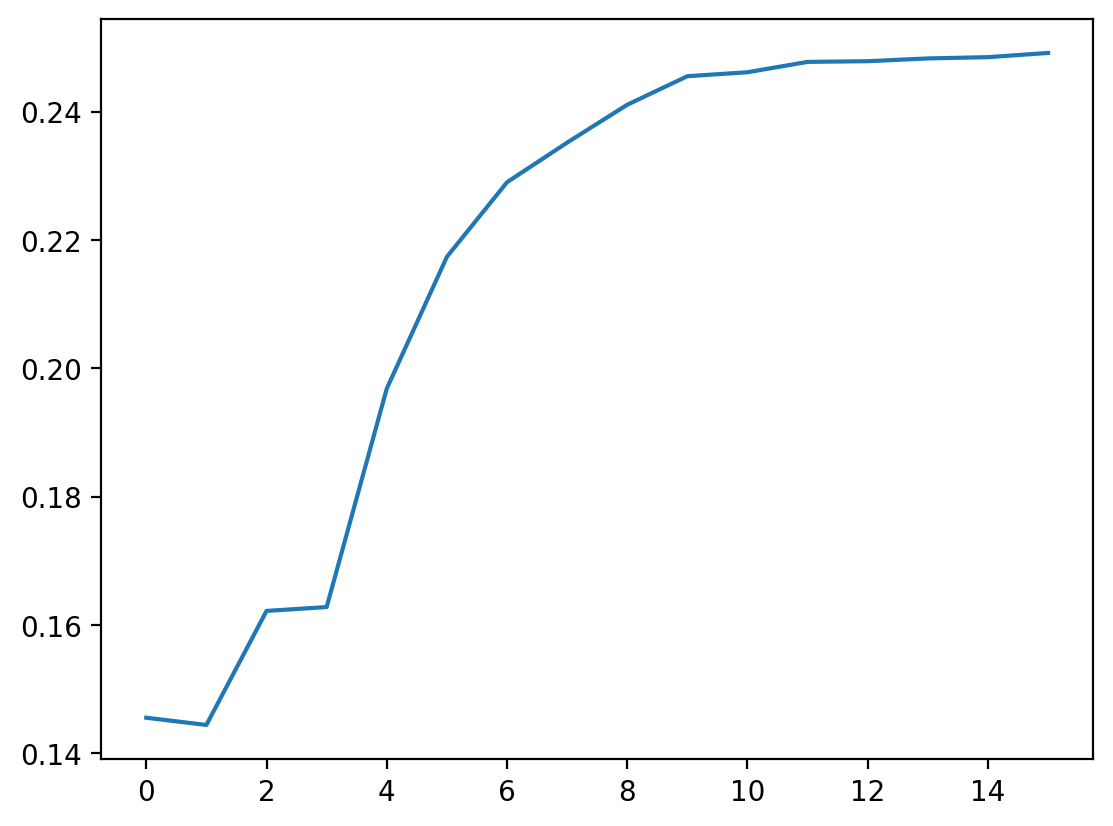

In [58]:
plt.plot(diameter_list_2d[0, :])

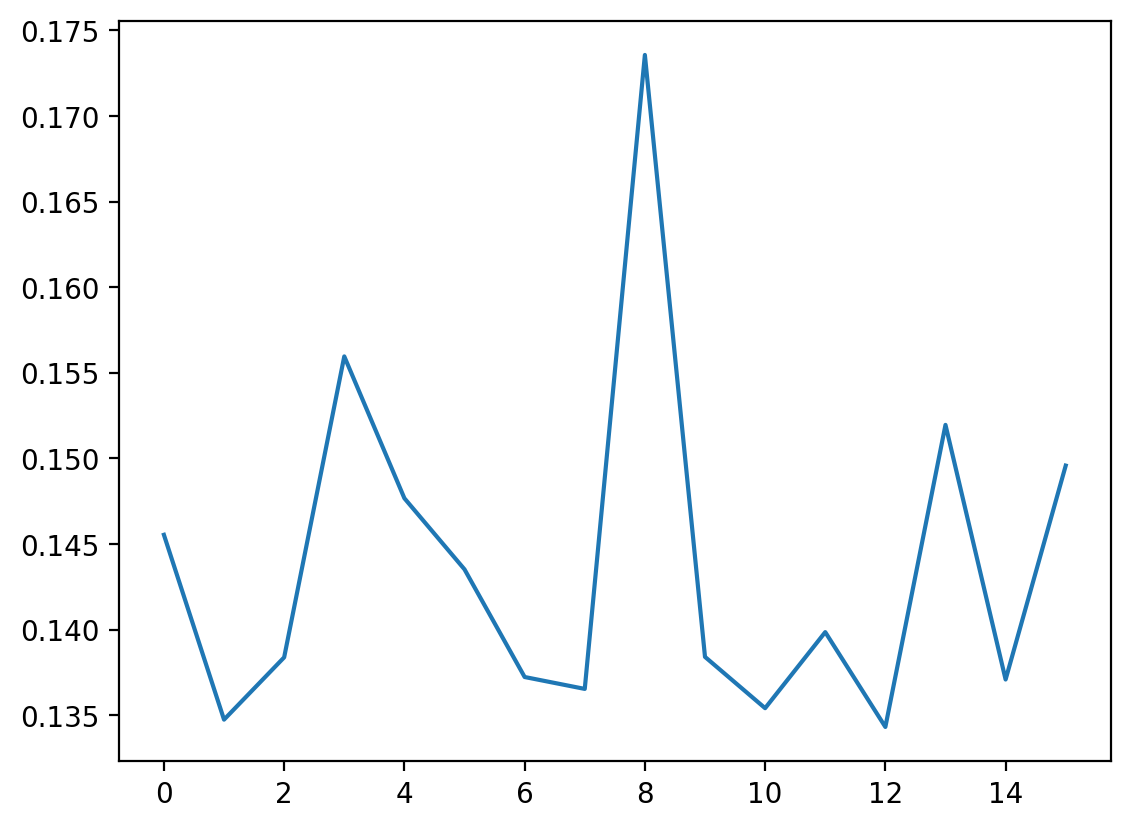

In [59]:
plt.plot(diameter_list_2d[: ,0])

In [95]:
area_list_s

array([[0.94115832, 0.98351481, 0.99569789, 1.00119997, 1.01131028,
        1.01139354, 1.01140127, 1.00950348, 1.01141628, 1.01120143],
       [0.94115832, 0.98351481, 0.99569789, 1.00119997, 1.01131028,
        1.01139354, 1.01140127, 1.00950348, 1.01141628, 1.01120143],
       [0.94115832, 0.98351481, 0.99569789, 1.00119997, 1.01131028,
        1.01139354, 1.01140127, 1.00950348, 1.01141628, 1.01120143],
       [0.94115832, 0.98351481, 0.99569789, 1.00119997, 1.01131028,
        1.01139354, 1.01140127, 1.00950348, 1.01141628, 1.01120143],
       [0.94115832, 0.98351481, 0.99569789, 1.00119997, 1.01131028,
        1.01139354, 1.01140127, 1.00950348, 1.01141628, 1.01120143],
       [0.94115832, 0.98351481, 0.99569789, 1.00119997, 1.01131028,
        1.01139354, 1.01140127, 1.00950348, 1.01141628, 1.01120143],
       [0.94115832, 0.98351481, 0.99569789, 1.00119997, 1.01131028,
        1.01139354, 1.01140127, 1.00950348, 1.01141628, 1.01120143],
       [0.94115832, 0.98351481, 0.9956978

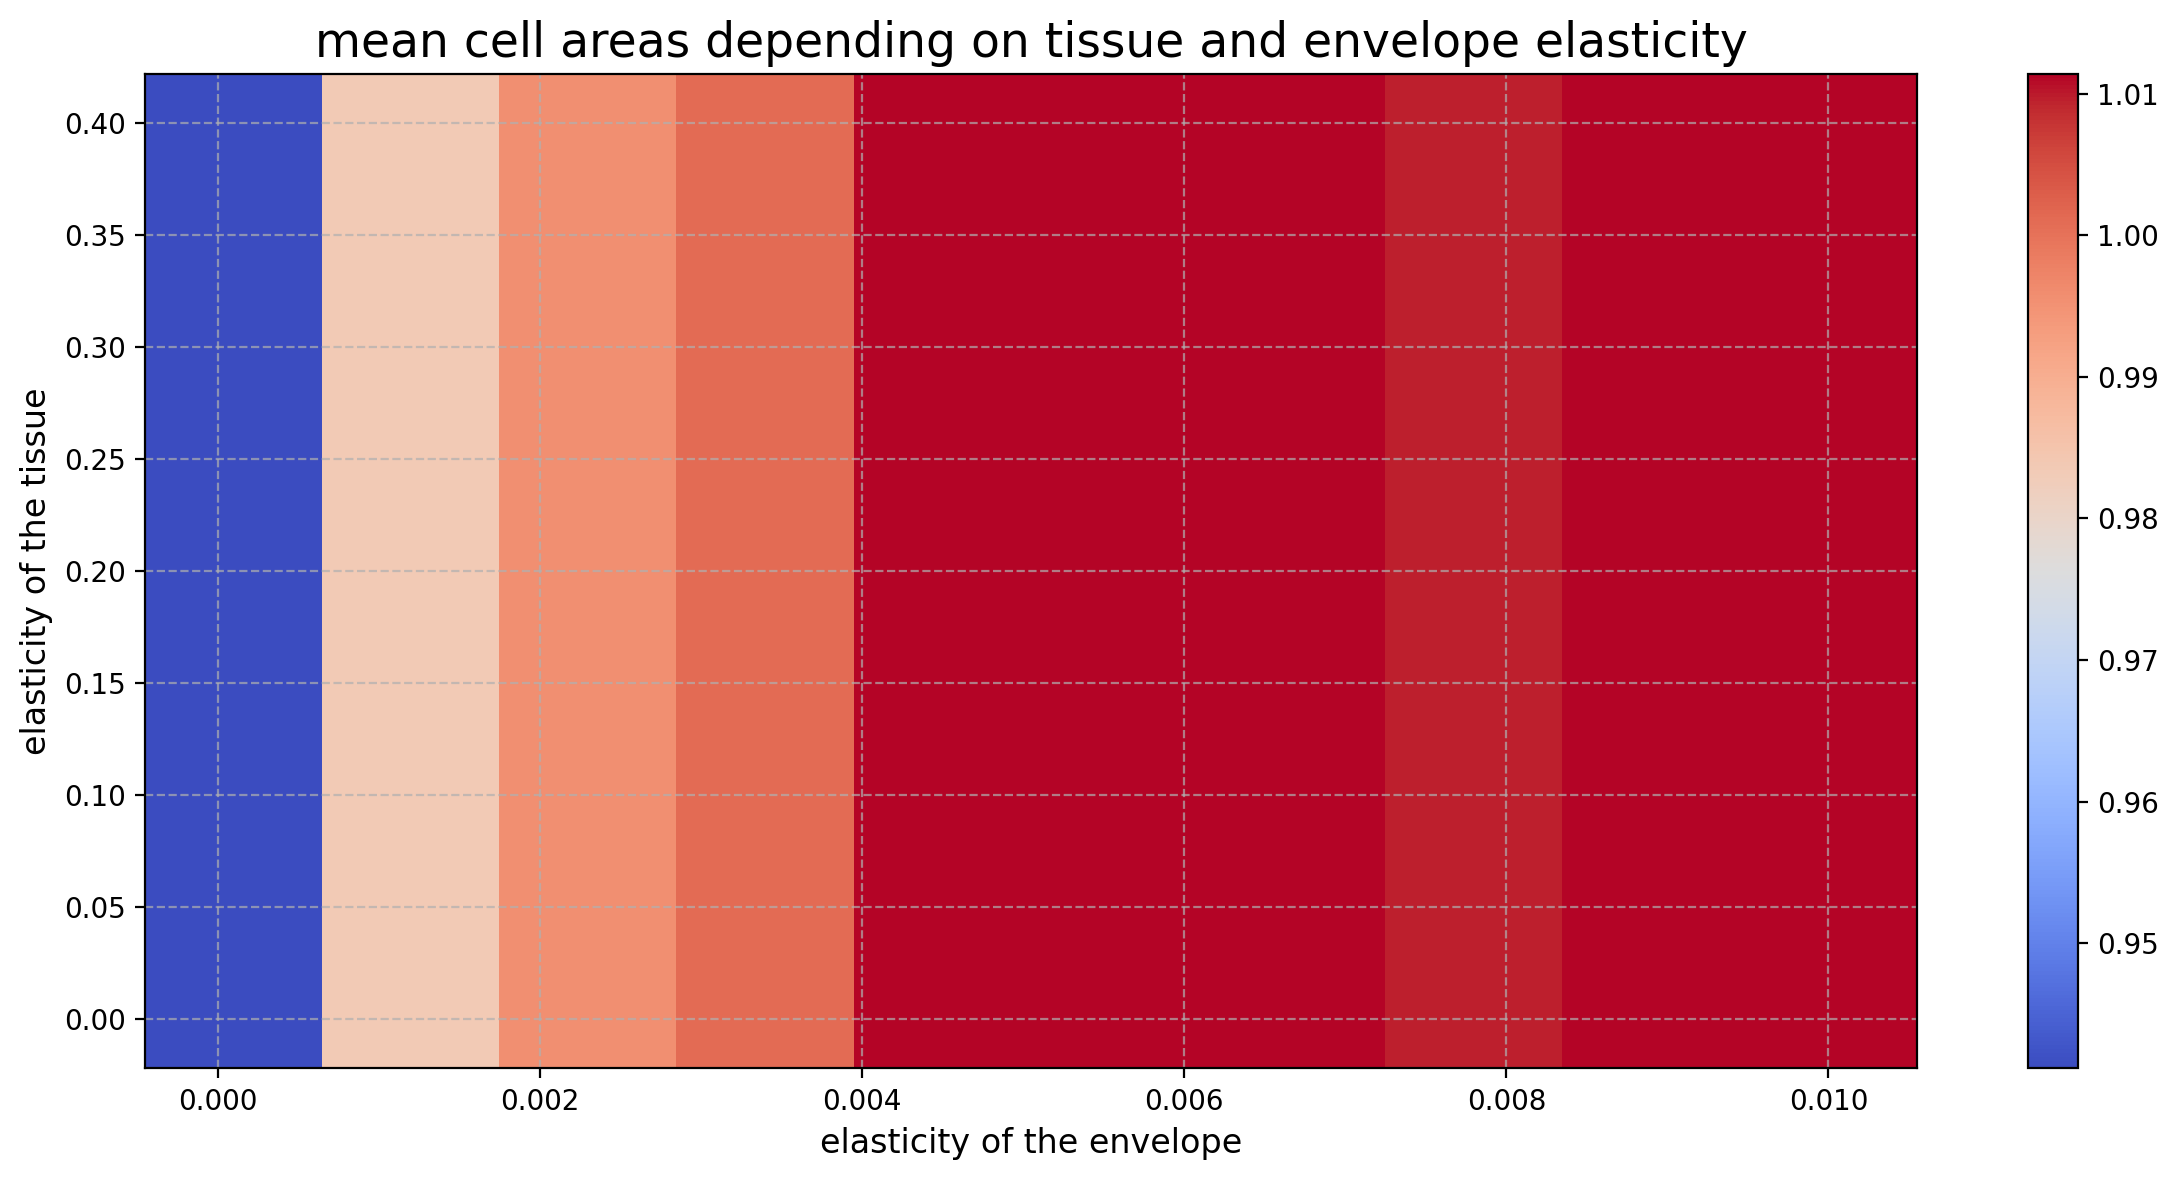

In [105]:
b_list_s = np.linspace(1e-4, 1e-2, 10)
l_list_s = np.linspace(0.0, 0.4, 10)
area_list_s = np.array(area_list)
area_list_s_2d = np.array(area_list_s).reshape(10, 10)

colors = plt.cm.viridis_r([0.2, 0.6])

fig, axs = plt.subplots(1, figsize=(12, 6))

c = axs.pcolor(b_list_s, l_list_s, area_list_2d, cmap='coolwarm', vmin=area_list_2d.min(), vmax=area_list_2d.max())
axs.grid(True, linestyle='--', alpha=0.7)
fig.colorbar(c, ax=axs)
plt.xlabel('elasticity of the envelope', fontsize=12)
plt.ylabel('elasticity of the tissue', fontsize=12)

plt.title('mean cell areas depending on tissue and envelope elasticity', fontsize=17)
plt.tight_layout()
plt.show()

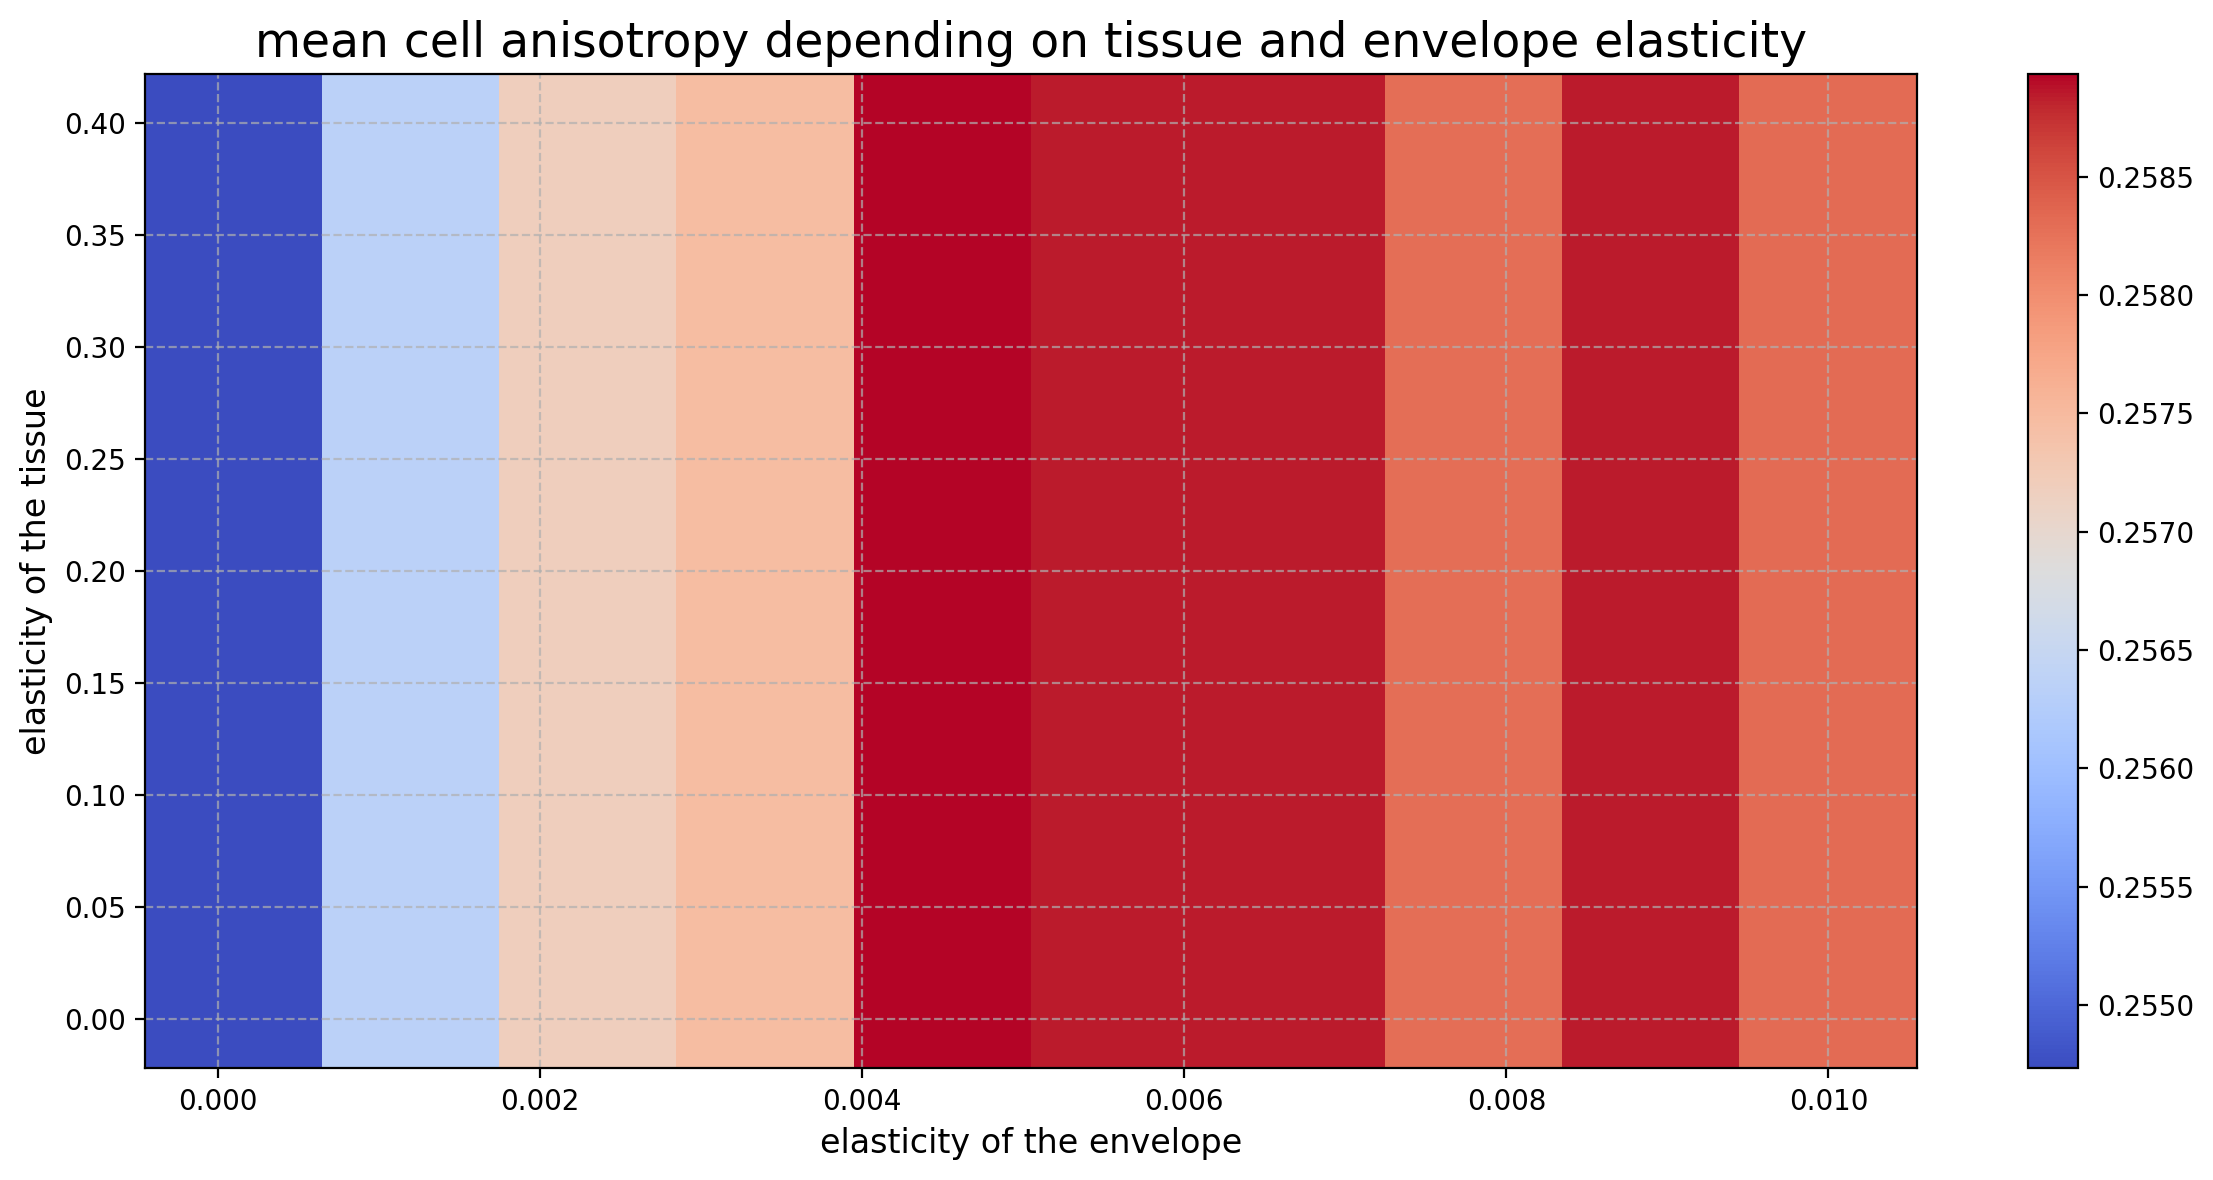

In [108]:
b_list_s = np.linspace(1e-4, 1e-2, 10)
l_list_s = np.linspace(0.0, 0.4, 10)
aniso_cell_list_s = np.array(area_list)
aniso_cell_list_2d = aniso_cell_list_s = np.array(aniso_cell_list).reshape(10, 10)

colors = plt.cm.viridis_r([0.2, 0.6])

fig, axs = plt.subplots(1, figsize=(12, 6))

c = axs.pcolor(b_list_s, l_list_s, aniso_cell_list_2d, cmap='coolwarm', vmin=aniso_cell_list_2d.min(), vmax=aniso_cell_list_2d.max())
axs.grid(True, linestyle='--', alpha=0.7)
fig.colorbar(c, ax=axs)
plt.xlabel('elasticity of the envelope', fontsize=12)
plt.ylabel('elasticity of the tissue', fontsize=12)

plt.title('mean cell anisotropy depending on tissue and envelope elasticity', fontsize=17)
plt.tight_layout()
plt.show()

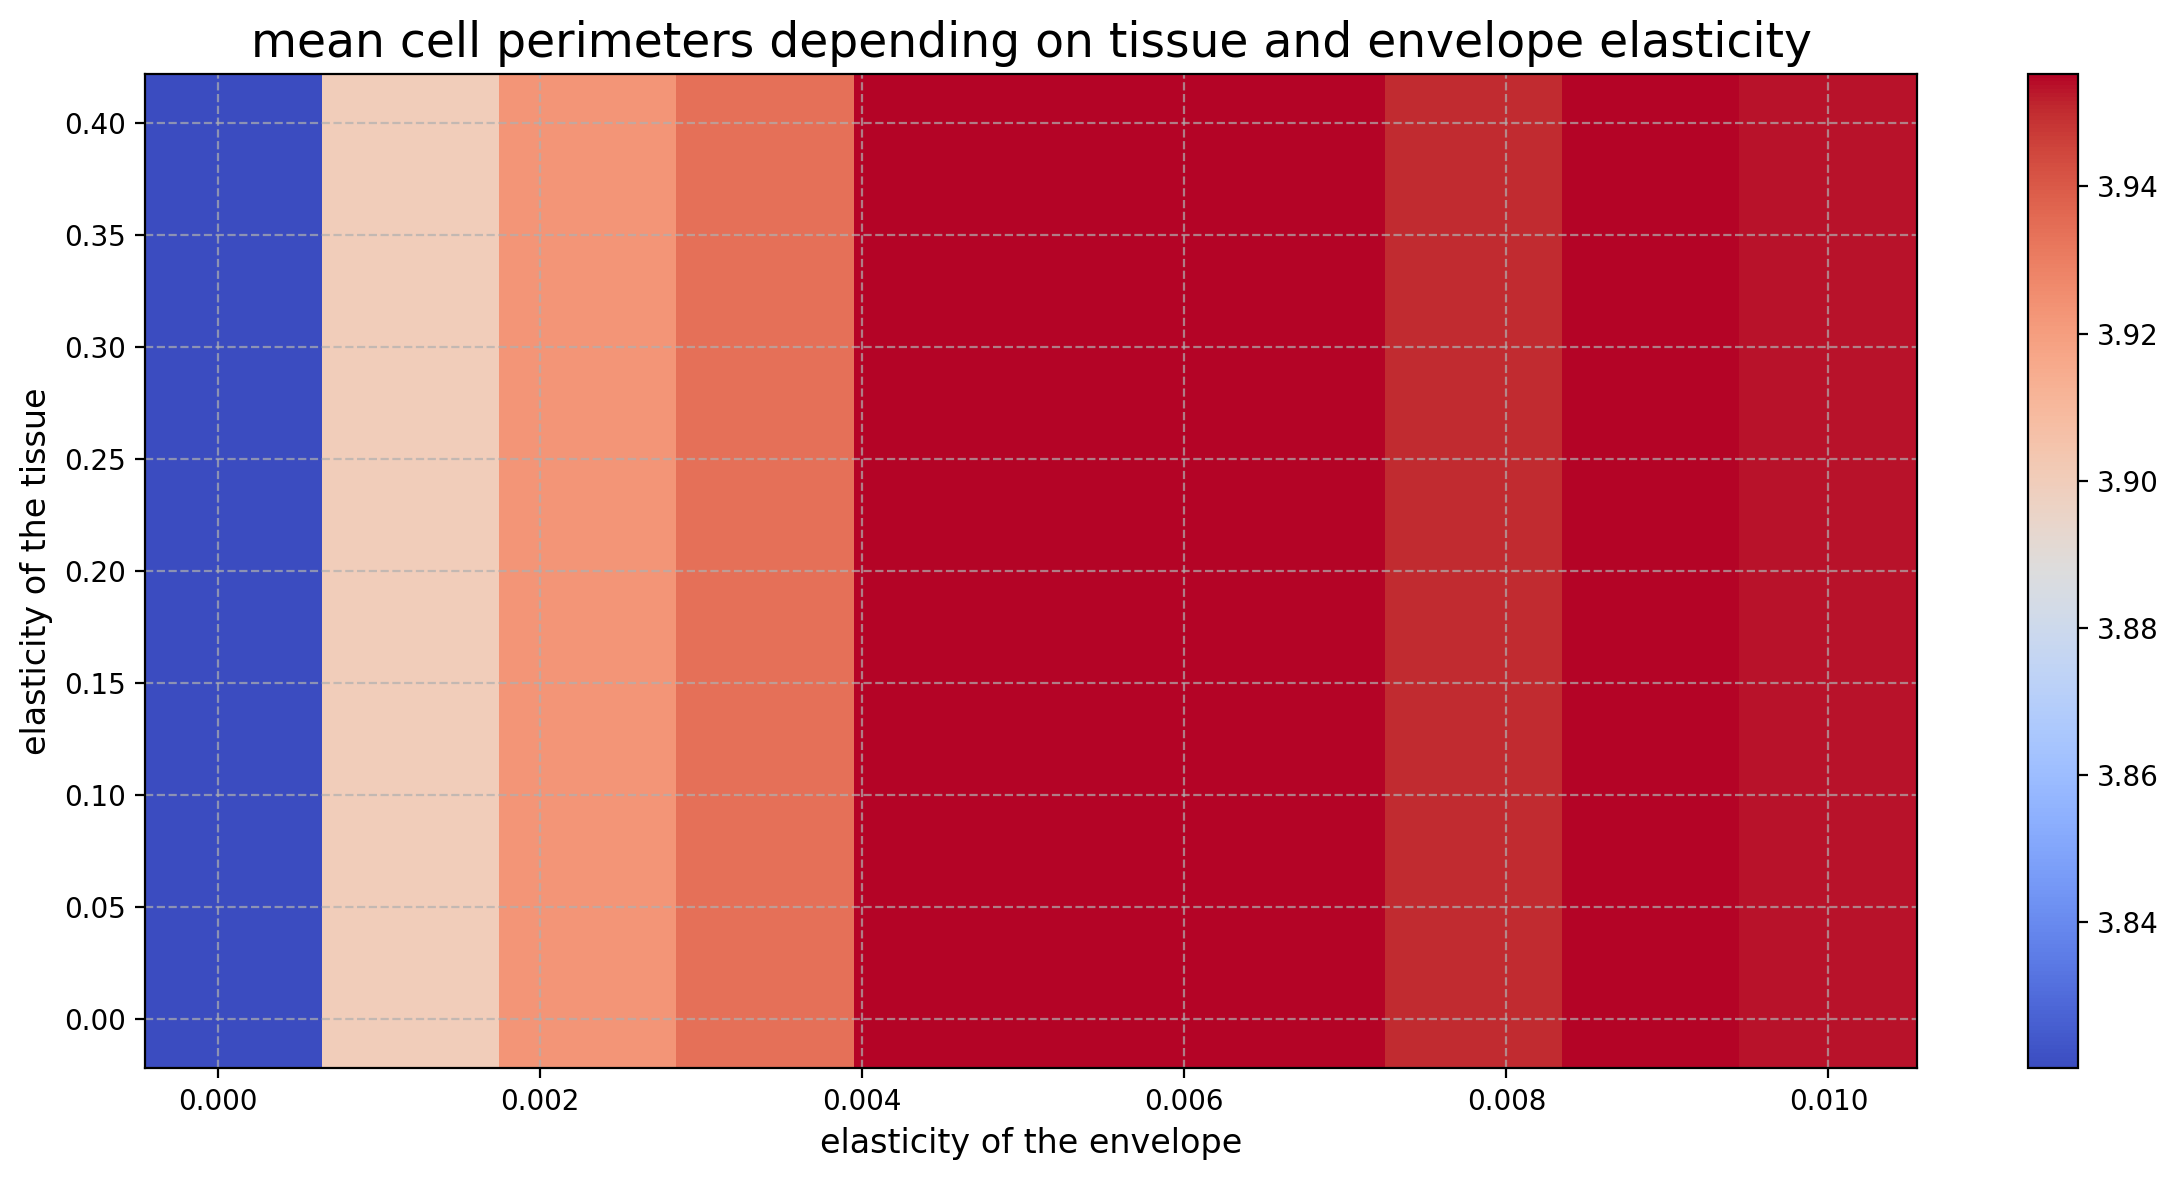

In [109]:
b_list_s = np.linspace(1e-4, 1e-2, 10)
l_list_s = np.linspace(0.0, 0.4, 10)
c_perimeter_s = np.array(c_perimeter)
c_perimeter_s_2d = np.array(c_perimeter_s).reshape(10, 10)

colors = plt.cm.viridis_r([0.2, 0.6])

fig, axs = plt.subplots(1, figsize=(12, 6))

c = axs.pcolor(b_list_s, l_list_s, c_perimeter_s_2d, cmap='coolwarm', vmin=c_perimeter_s_2d.min(), vmax=c_perimeter_s_2d.max())
axs.grid(True, linestyle='--', alpha=0.7)
fig.colorbar(c, ax=axs)
plt.xlabel('elasticity of the envelope', fontsize=12)
plt.ylabel('elasticity of the tissue', fontsize=12)

plt.title('mean cell perimeters depending on tissue and envelope elasticity', fontsize=17)
plt.tight_layout()
plt.show()